## Install hopsworks

In [3]:
!pip uninstall hopsworks hsfs hsml -y

!pip install hopsworks[python]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 4.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.6/258.6 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 640.3/640.3 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Imports

In [42]:
import os
import requests

from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt

#Models
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error, r2_score

import hopsworks
import json
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Feature importance behövs
#EDA med features och imdb rating

## Read data from Hopsworks

In [67]:
project = hopsworks.login(project="dbillLab1")
fs = project.get_feature_store()

movie_fg = fs.get_feature_group(
    name='tmdb_movies',
    version=1,
)

genres_fg= fs.get_feature_group(
    name='tmdb_movie_genres',
    version=1,
)

selected_features = movie_fg.select(['title','release_date', 'revenue', 'runtime', 'budget',
                                     'original_language', 'imdb_rating',
                                     'production_countries', 'imdb_votes']).join(genres_fg.select_all(), on=['id'])


Connection closed.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1169559


In [68]:
selected_features.show(10)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.93s) 


,title,release_date,revenue,runtime,budget,original_language,imdb_rating,production_countries,imdb_votes,id,...,history,horror,music,mystery,romance,science_fiction,tv_movie,thriller,war,western
0,Moscow Heat,2004-11-24,840201.0,89.0,0.0,en,2.5,Russia,2438.0,106546,...,0,0,0,0,0,0,0,1,0,0
1,A Killing Affair,1977-09-21,0.0,100.0,0.0,en,6.1,United States of America,125.0,5526,...,0,0,0,0,0,0,1,0,0,0
2,Top Secret,1952-11-10,0.0,93.0,0.0,en,6.3,United Kingdom,201.0,194432,...,0,0,0,0,0,0,0,0,0,0
3,The Man Who Could Work Miracles,1936-07-23,0.0,82.0,0.0,en,6.9,United Kingdom,1647.0,68849,...,0,0,0,0,0,0,0,0,0,0
4,Them Who?,2015-11-19,0.0,95.0,0.0,it,6.4,Italy,1910.0,369230,...,0,0,0,0,0,0,0,0,0,0
5,She Freak,1967-05-03,0.0,83.0,0.0,en,3.6,United States of America,1259.0,30935,...,0,1,0,0,0,0,0,0,0,0
6,More Than Meets the Eye: The Joan Brock Story,2003-06-16,0.0,120.0,0.0,en,6.4,Canada,181.0,113192,...,0,0,0,0,0,0,1,0,0,0
7,Five,1951-04-25,0.0,93.0,0.0,en,6.3,United States of America,1693.0,48481,...,0,0,0,0,0,1,0,0,0,0
8,The Manitou,1978-04-28,0.0,104.0,0.0,en,5.4,"Canada, United States of America",3452.0,40060,...,0,1,0,0,0,1,0,0,0,0
9,Cold Feet,1989-05-19,290000.0,94.0,0.0,en,4.8,United States of America,477.0,88658,...,0,0,0,0,0,0,0,0,0,0


In [69]:
# Creating a feature view
feature_view = fs.get_or_create_feature_view(
    name='tmdb_fv',
    description="movie features with imdb rating as the target",
    version=1,
    labels=['imdb_rating'],
    query=selected_features,
)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1169559/fs/1160262/fv/tmdb_fv/version/1


In [94]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(test_size=0.2, random_state=48)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.57s) 


In [95]:
X_train.head()

,title,release_date,revenue,runtime,budget,original_language,production_countries,imdb_votes,id,timestamp,...,history,horror,music,mystery,romance,science_fiction,tv_movie,thriller,war,western
0,Moscow Heat,2004-11-24,840201.0,89.0,0.0,en,Russia,2438.0,106546,2025-01-04 00:00:00+00:00,...,0,0,0,0,0,0,0,1,0,0
1,A Killing Affair,1977-09-21,0.0,100.0,0.0,en,United States of America,125.0,5526,2025-01-04 00:00:00+00:00,...,0,0,0,0,0,0,1,0,0,0
3,The Man Who Could Work Miracles,1936-07-23,0.0,82.0,0.0,en,United Kingdom,1647.0,68849,2025-01-04 00:00:00+00:00,...,0,0,0,0,0,0,0,0,0,0
5,She Freak,1967-05-03,0.0,83.0,0.0,en,United States of America,1259.0,30935,2025-01-04 00:00:00+00:00,...,0,1,0,0,0,0,0,0,0,0
7,Five,1951-04-25,0.0,93.0,0.0,en,United States of America,1693.0,48481,2025-01-04 00:00:00+00:00,...,0,0,0,0,0,1,0,0,0,0


In [105]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
# Label encoding categorical features

X_train['production_countries'] = label_encoder.fit_transform(X_train['production_countries'])
X_train['original_language'] = label_encoder.fit_transform(X_train['original_language'])

X_test['production_countries'] = label_encoder.fit_transform(X_test['production_countries'])
X_test['original_language'] = label_encoder.fit_transform(X_test['original_language'])

#X_train.head()
print(X_train['production_countries'].unique())
print(X_train['original_language'].unique())

[1092 1263 1207 ...  333 1212  512]
[14 29 23 35 15 63 30 50 52 64 11 20  7 60 61 10 41 27 48 46 66  6 62 19
 43  8 72  2 16 34 22 49  1 25 28 67 45 37 31 56 47  4 17 73 18 70 13 36
 21 40 69 65 42 38 57 26 24  3 51 68 55 58  0 71  9 39 53 59 33 54 44 32
 12  5]


# Training models
XGBoost, RandomForest, Linear Regression, SVR, DecisionTree

In [ ]:
xgb_model= XGBRegressor()
rf_model= RandomForestRegressor(random_state=48)
lr_model= LinearRegression()
svr_model= SVR()
dt_model= DecisionTreeRegressor(random_state=48)

models={
    "XGBoost": xgb_model,
    "Random Forest": rf_model,
    "Linear Regression": lr_model,
    "SVR": svr_model,
    "Decision Tree": dt_model
}

## With categorical features
Removed production countries as they could have several values and majority had the U.S

In [109]:
with_cat=['id', 'title','timestamp','release_date', 'production_countries']

train_features= X_train.drop(with_cat, axis=1)
test_features = X_test.drop(with_cat, axis=1)

for name, model in models.items():
    model.fit(train_features, y_train)
    print(name)
    y_pred= model.predict(test_features)
    mse= mean_squared_error(y_test.iloc[:,0], y_pred)
    print("MSE:", mse)
    r2 = r2_score(y_test.iloc[:,0], y_pred)
    print("R squared:", r2)
    print('_________')

XGBoost
MSE: 1.1846401076888688
R squared: 0.08530996649656886
_________
Random Forest
MSE: 0.831910110044991
R squared: 0.3576615535046974
_________
Linear Regression
MSE: 0.9019432442748524
R squared: 0.30358723213123406
_________
SVR
MSE: 1.2291551947092936
R squared: 0.050938762808761195
_________
Decision Tree
MSE: 1.555078307392996
R squared: -0.20071456289350809
_________


## Without categorical features
Removed original language as well since half of the dataset had "en" (english). Removing this feature led to a lower MSE.

In [110]:
drop_list=['id', 'title','timestamp','release_date', 'original_language', 'production_countries']

print("Dropped:", drop_list, "\n")
train_features= X_train.drop(drop_list, axis=1)
test_features = X_test.drop(drop_list, axis=1)

for name, model in models.items():
    model.fit(train_features, y_train)
    print(name)
    y_pred= model.predict(test_features)
    mse= mean_squared_error(y_test.iloc[:,0], y_pred)
    print("MSE:", mse)
    r2 = r2_score(y_test.iloc[:,0], y_pred)
    print("R squared:", r2)
    print('_________')

Dropped: ['id', 'title', 'timestamp', 'release_date', 'original_language', 'production_countries'] 

XGBoost
MSE: 0.7063814662361363
R squared: 0.45458533539079715
_________
Random Forest
MSE: 0.7557413416997406
R squared: 0.41647335028368204
_________
Linear Regression
MSE: 0.9020703470797345
R squared: 0.30348909290050785
_________
SVR
MSE: 1.2291263662937817
R squared: 0.05096102194398666
_________
Decision Tree
MSE: 1.3457324902723737
R squared: -0.039073460897190326
_________


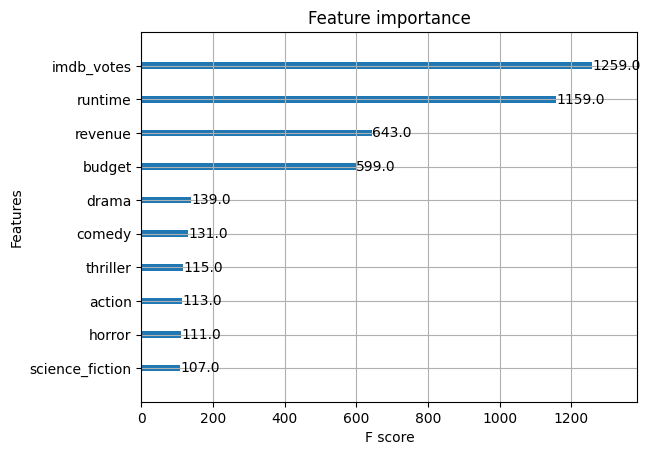

In [111]:
plot_importance(xgb_model, max_num_features=10)
plt.show()

In [ ]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

model_dir="movie_rating_model"

# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(train_features)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

mr = project.get_model_registry()

# Creating a Python model in the model registry named 'movie_rating_xgboost_model' for the best model XGBoost
movie_rating_pred_model = mr.python.create_model(
    name="movie_rating_xgboost_model", 
    metrics= res_dict,
    model_schema=model_schema,
    input_example=X_test.sample().values, 
    description="Movie Rating (1-10) predictor",
)

# Saving the model artifacts to the 'movie_rating_model' directory in the model registry
movie_rating_pred_model.save(model_dir)

: 